# Analyzing synthetic annotations

This notebook is dedicated to exploring and analyzing the LLM annotations produced on the LLM conversations.

More specifically, we will be exploring whether different chat-user personas, and/or annotator personas influence the LLM toxicity annotation scores. Formulating these formally, we test the following two hypotheses:

* **Hypothesis 1**: Different socio-demographic background (SDB) prompts for the LLM *participants of the conversation* influence the toxicity of the conversations
* **Hypothesis 2**: Different socio-demographic background (SDB) prompts for the LLM *annotators of the conversation* influence the toxicity *for the same* given conversation

## Loading the synthetic conversations & annotations

In [1]:
import sys 
import os


sys.path.append(os.path.abspath('..'))

In [2]:
import lib.util
import tasks.preprocessing
import tasks.results
import tasks.stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import scipy.stats
import scikit_posthocs
import diptest

import textwrap


GRAPH_OUTPUT_DIR = "../output/graphs" 
CONVERSATIONS_INPUT_DIR = "../output/conversations"
ANNOTATIONS_INPUT_DIR = "../output/annotations"
CSV_OUTPUT_DIR = "../output/csv"
SNS_FONT_SIZE = 1.5

sns.set(font_scale=SNS_FONT_SIZE)

We load each conversation and place them in a pandas dataframe

In [3]:
def name_conv_cariants(conv_variant: str) -> str:
    match conv_variant:
        case "game_improved":
            return "game"
        case "game_improved_no_mod":
            return "game_no_mod"
        case "polarized_vanilla":
            return "vanilla"
        case "polarized_vanilla_no_mod":
            return "vanilla_no_mod"
        case _:
            raise ValueError(
                f"Conv variant id {conv_variant} does not match any known ids:"
                "Edit the name_conv_variants function to include it!"
            )

In [4]:
conv_df = tasks.preprocessing.import_conversations(CONVERSATIONS_INPUT_DIR)
conv_df = conv_df[conv_df.message.str.len() > 0]
conv_df.conv_variant = conv_df.conv_variant.map(name_conv_cariants)
conv_df

,id,timestamp,users,user_types,moderator,moderator_type,user_prompts,moderator_prompt,ctx_length,conv_variant,user,message
0,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...
0,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,moderator01,"Steve2001, thank you for sharing your perspect..."
0,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,GeorgeBush78,"Oh come on Steve2001, don't be so sensitive! I..."
0,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,moderator01,"As moderator01, I would like to point out that..."
0,5c726b64-7ec9-4132-ad0d-690b8cf7de98,24-07-19-13-39,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,"Hey, I don't think that's a fair statement. Be..."
...,...,...,...,...,...,...,...,...,...,...,...,...
0,406639c0-6bb7-4854-9451-98795419c155,24-07-10-14-00,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,vanilla,moderator01,"GeorgeBush78, your comment is not appropriate...."
0,406639c0-6bb7-4854-9451-98795419c155,24-07-10-14-00,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,vanilla,Steve2001,"Oh come on, moderator01! You're just censoring..."
0,406639c0-6bb7-4854-9451-98795419c155,24-07-10-14-00,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,vanilla,moderator01,"Steve2001, your behavior is not appropriate. Y..."
0,406639c0-6bb7-4854-9451-98795419c155,24-07-10-14-00,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,vanilla,GeorgeBush78,"Oh come on, moderator01! You're being way too ..."


In [5]:
conv_df = conv_df.set_index("id")

We do the same for their annotations, which are given as sepearate "conversations":

In [6]:
annot_df = tasks.preprocessing.import_annotations(
    ANNOTATIONS_INPUT_DIR, round=True,sentinel_value=-1
).dropna()
annot_df = annot_df[annot_df.toxicity != -1]
annot_df.toxicity = annot_df.toxicity.astype(int)
annot_df

,conv_id,timestamp,annotator_type,annotator_prompt,ctx_length,message,toxicity
0,fb8363f1-3e73-443d-b71e-f52b0e89ded1,24-07-28-13-21,LLMAnnotator,"a 30 year-old, college professor, on humanity...",4,Hey there! I saw your post about the baker and...,3
0,fb8363f1-3e73-443d-b71e-f52b0e89ded1,24-07-28-13-21,LLMAnnotator,"a 30 year-old, college professor, on humanity...",4,"Steve2001, thank you for sharing your perspect...",3
0,fb8363f1-3e73-443d-b71e-f52b0e89ded1,24-07-28-13-21,LLMAnnotator,"a 30 year-old, college professor, on humanity...",4,"Hey Steve2001, I hear what you're saying, but ...",3
0,fb8363f1-3e73-443d-b71e-f52b0e89ded1,24-07-28-13-21,LLMAnnotator,"a 30 year-old, college professor, on humanity...",4,"GeorgeBush78, thank you for your input. Steve2...",3
0,fb8363f1-3e73-443d-b71e-f52b0e89ded1,24-07-28-13-21,LLMAnnotator,"a 30 year-old, college professor, on humanity...",4,"Hey Moderator01, I appreciate your question. B...",3
...,...,...,...,...,...,...,...
0,32aff8eb-9ab3-4b56-b6be-95d21936e3f4,24-07-22-14-20,LLMAnnotator,"a expert, typical, average, white, American",4,,3
0,32aff8eb-9ab3-4b56-b6be-95d21936e3f4,24-07-22-14-20,LLMAnnotator,"a expert, typical, average, white, American",4,Please select one of the following options t...,3
0,32aff8eb-9ab3-4b56-b6be-95d21936e3f4,24-07-22-14-20,LLMAnnotator,"a expert, typical, average, white, American",4,"What's up with you, man? You got some serious ...",3
0,32aff8eb-9ab3-4b56-b6be-95d21936e3f4,24-07-22-14-20,LLMAnnotator,"a expert, typical, average, white, American",4,,3


... and combine both in order to have a dataframe representing each comment in the conversation alongside its assigned toxicity score by the multiple annotators.

In [7]:
full_df = pd.merge(
    conv_df,
    annot_df,
    left_on=["id", "message"],
    right_on=["conv_id", "message"],
    how="inner",
)

full_df.head()

,timestamp_x,users,user_types,moderator,moderator_type,user_prompts,moderator_prompt,ctx_length_x,conv_variant,user,message,conv_id,timestamp_y,annotator_type,annotator_prompt,ctx_length_y,toxicity
0,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-28-13-23,LLMAnnotator,"a 30 year-old, college professor, on humanity...",4,3
1,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-28-12-30,LLMAnnotator,"a 45-year-old, construction worker",4,3
2,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-28-12-48,LLMAnnotator,"a 18-year-old, gamer",4,3
3,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-28-13-05,LLMAnnotator,"a 73 year-old, grandma, unfamiliar with new d...",4,3
4,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-23-12-30,LLMAnnotator,a neutral,4,3


In [8]:
def simplify_labels(text):
    if "African American" in text:
        return "African American"
    elif "LGBT" in text:
        return "LGBTQ+"
    elif "neutral" in text:
        return "W.E.I.R.D."
    elif "typical" in text:
        return "No SDB"
    elif "construction" in text:
        return "Blue collar"
    elif "professor" in text:
        return "Professor"
    elif "gamer" in text:
        return "Gamer"
    elif "grandma" in text:
        return "Grandma"
    else:
        raise Exception("Invalid label name: ", text)


full_df.annotator_prompt = full_df.annotator_prompt.apply(simplify_labels)
full_df.head()

,timestamp_x,users,user_types,moderator,moderator_type,user_prompts,moderator_prompt,ctx_length_x,conv_variant,user,message,conv_id,timestamp_y,annotator_type,annotator_prompt,ctx_length_y,toxicity
0,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-28-13-23,LLMAnnotator,Professor,4,3
1,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-28-12-30,LLMAnnotator,Blue collar,4,3
2,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-28-12-48,LLMAnnotator,Gamer,4,3
3,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-28-13-05,LLMAnnotator,Grandma,4,3
4,24-07-19-14-26,"[Steve2001, GeorgeBush78]","[LlmActor, LlmActor]",moderator01,LlmActor,[Model: LlamaModel. Prompt: You are Steve2001 ...,Model: LlamaModel. Prompt: You are moderator01...,4,game,Steve2001,Hey there! I see you're spouting some pretty e...,0202c75c-7d71-4b02-9cc3-f6c74da2af1e,24-07-23-12-30,LLMAnnotator,W.E.I.R.D.,4,3


## Analyzing the annotators


*IMPORTANT NOTE*

`W.E.I.R.D.` (Western, Educated, Industrialized, Rich, and Democratic) means that the LLM is given the **default demographic** (all of the above characteristics not explicitly stated, but implied in the prompt).

### Do annotator socio-demographic (SD) prompts lead to different judgements?

The first question would be whether giving a different background to the annotator LLM changes how they perceive toxicity.

A barplot showing the aggregate counts for each LLM annotator prompt can give us a general idea on whether some annotators judge controversial conversations as toxic, in general.

Figure saved to ../output/graphs/toxicity_by_annotator.png


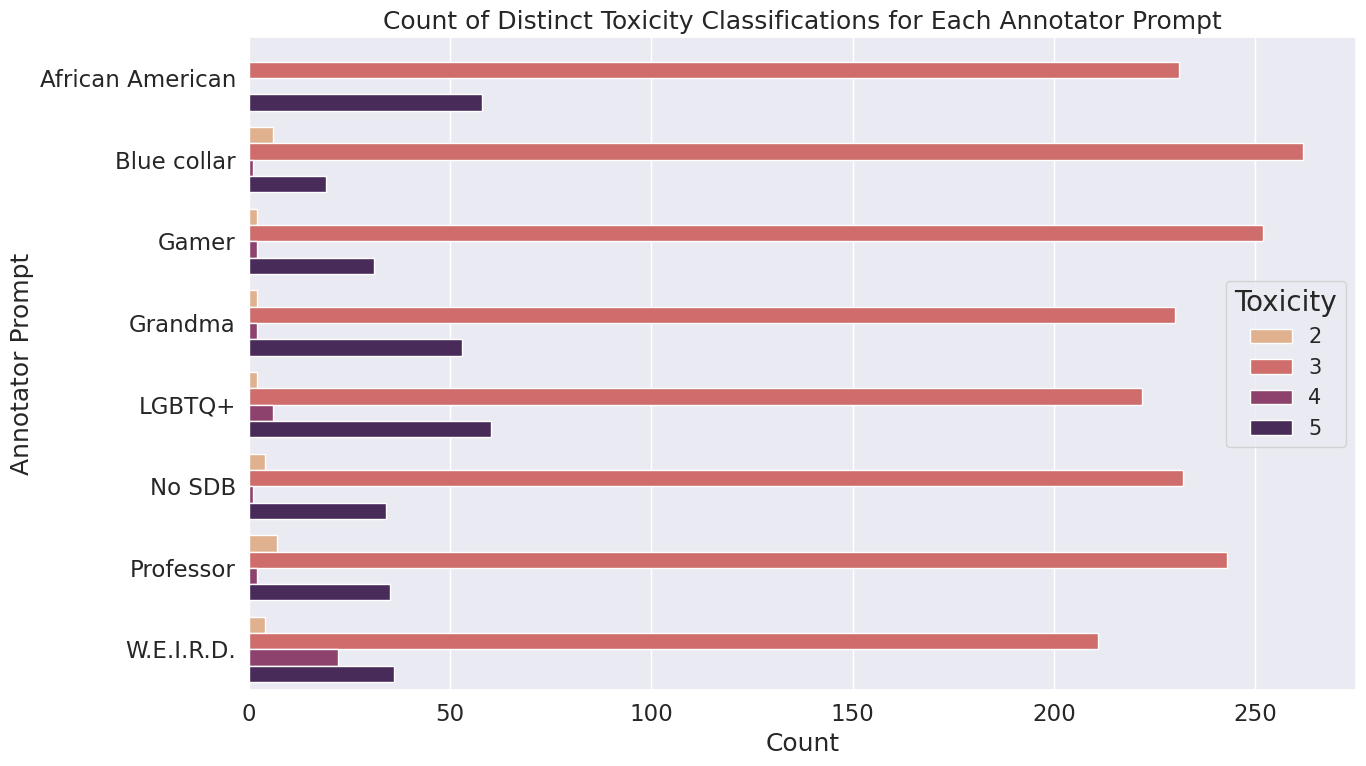

In [9]:
# Calculate the count of each toxicity classification per annotator_prompt
toxicity_counts = (
    full_df.groupby(["annotator_prompt", "toxicity"]).size().reset_index(name="count")
)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(
    data=toxicity_counts,
    y="annotator_prompt",
    x="count",
    hue="toxicity",
    palette="flare",
)
plt.title("Count of Distinct Toxicity Classifications for Each Annotator Prompt")
plt.ylabel("Annotator Prompt")
plt.xlabel("Count")
plt.legend(title="Toxicity", fontsize="15", title_fontsize="20")
plt.tight_layout()

lib.util.save_plot(filename="toxicity_by_annotator.png", dir_name=GRAPH_OUTPUT_DIR)
plt.show()


We note the following observations:

* The vast majority of conversations are marked as *moderately toxic* by all annotators
* LGBT and African-American LLM annotators tend to perceive posts as more toxic than more "conservative-leaning" prompts

We can verify that these deviations are significant using the Kruskal-Wallis ANOVA ranked test.

In [10]:
grouped = full_df.groupby('annotator_prompt')['toxicity'].apply(list)
toxicity_groups = grouped.tolist()
_, p = scipy.stats.kruskal(*toxicity_groups)
print("H_0: mean toxicity between annotator demograhics are the same: p=", p)

H_0: mean toxicity between annotator demograhics are the same: p= 2.2141405567175005e-08


However, just knowing that deviations exist does not imply that the differences are between the progressive-leaning and conservative-leaning personas. Thus, we run a posthoc Dunn test.

Figure saved to ../output/graphs/dunns_annotator.png


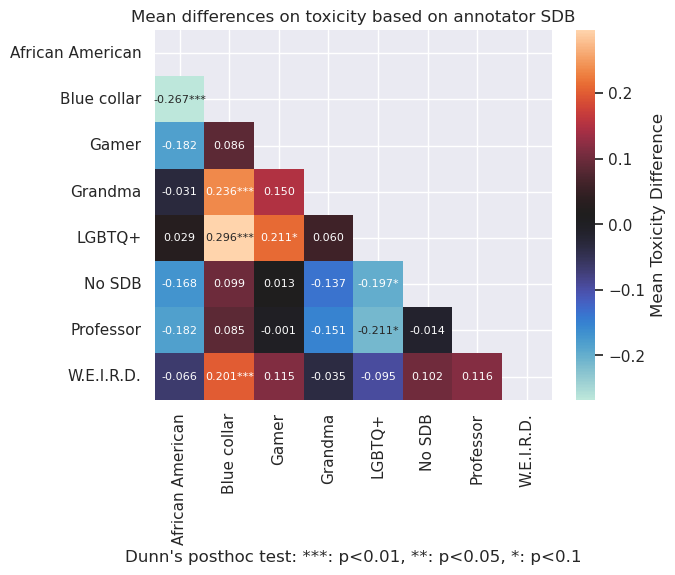

In [11]:
sns.set(font_scale=1)
posthoc_df = tasks.stats.posthoc_dunn(full_df, val_col="toxicity", group_col="annotator_prompt")
value_df = tasks.stats.pairwise_diffs(full_df, groupby_cols=['conv_variant', 'annotator_prompt'], value_col="toxicity")

tasks.results.pvalue_heatmap(
    value_df=value_df,
    pvalue_df=posthoc_df,
    show_labels=True,
    correlation_title="Mean differences on toxicity based on annotator SDB",
    xlabel_text="Dunn's posthoc test: ***: p<0.01, **: p<0.05, *: p<0.1",
    filename="dunns_annotator.png",
    output_dir=GRAPH_OUTPUT_DIR
)
sns.set(font_scale=SNS_FONT_SIZE)

While there are definitely stastically significant deviations between the annotator SDB prompts, these do not translate to a large qualitative difference (+- 0.3 mean change in toxicity).

### Do different conversation setups lead to different toxicity in comments? 

We now tackle Hypothesis 1. Do different participant prompts lead to more/less toxic conversations? 

Figure saved to ../output/graphs/toxicity_by_annotator_conversation.png


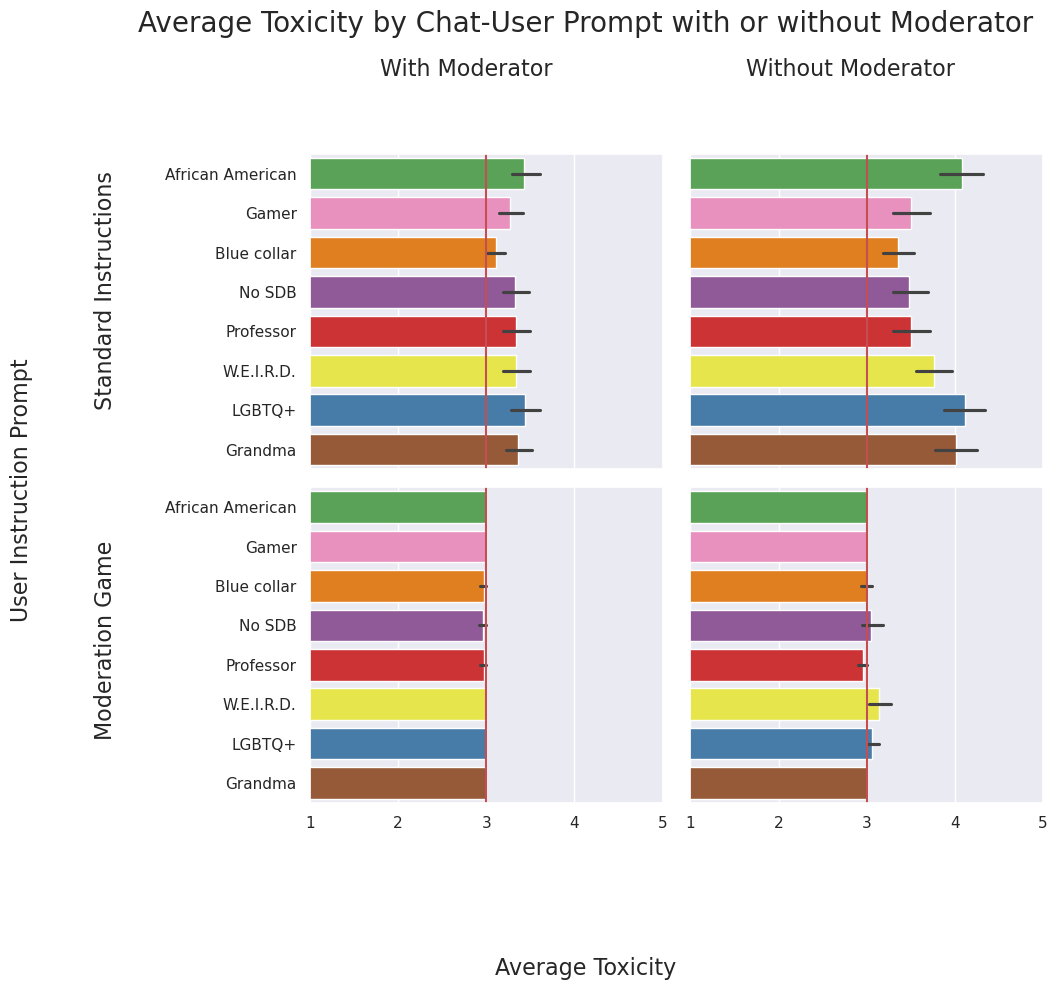

In [12]:
SECONDARY_LABEL_FONTSIZE = 16
sns.set(font_scale=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Filter data
vanilla_df = full_df[full_df["conv_variant"].str.contains("vanilla")]
game_df = full_df[full_df["conv_variant"].str.contains("game")]

# Split data by moderator presence
vanilla_with_mod = vanilla_df[~vanilla_df["conv_variant"].str.contains("no_mod")]
vanilla_without_mod = vanilla_df[vanilla_df["conv_variant"].str.contains("no_mod")]
game_with_mod = game_df[~game_df["conv_variant"].str.contains("no_mod")]
game_without_mod = game_df[game_df["conv_variant"].str.contains("no_mod")]

# Consistent color palette across plots
# https://stackoverflow.com/questions/76581181/how-do-you-preserve-hue-associations-across-multiple-plots-in-seaborn
keys = vanilla_df.annotator_prompt.unique()
colors = dict(zip(keys, sns.color_palette("Set1")))

tasks.results.toxicity_barplot(vanilla_with_mod, axes[0, 0], color_palette=colors)
tasks.results.toxicity_barplot(vanilla_without_mod, axes[0, 1], color_palette=colors)
tasks.results.toxicity_barplot(game_with_mod, axes[1, 0], color_palette=colors)
tasks.results.toxicity_barplot(game_without_mod, axes[1, 1], color_palette=colors)

fig.suptitle("Average Toxicity by Chat-User Prompt with or without Moderator", fontsize=20)
fig.supxlabel("Average Toxicity", fontsize=SECONDARY_LABEL_FONTSIZE)
fig.supylabel("User Instruction Prompt", fontsize=SECONDARY_LABEL_FONTSIZE)

# Add secondary y-axis labels
fig.text(
    0.1,
    0.7,
    "Standard Instructions",
    va="center",
    ha="center",
    rotation="vertical",
    fontsize=SECONDARY_LABEL_FONTSIZE,
)
fig.text(
    0.1,
    0.35,
    "Moderation Game",
    va="center",
    ha="center",
    rotation="vertical",
    fontsize=SECONDARY_LABEL_FONTSIZE,
)

# Add secondary x-axis labels
fig.text(
    0.4,
    0.92,
    "With Moderator",
    va="center",
    ha="center",
    fontsize=SECONDARY_LABEL_FONTSIZE,
)
fig.text(
    0.72,
    0.92,
    "Without Moderator",
    va="center",
    ha="center",
    fontsize=SECONDARY_LABEL_FONTSIZE,
)

plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])

# Save and display
lib.util.save_plot(
    filename="toxicity_by_annotator_conversation.png", dir_name=GRAPH_OUTPUT_DIR
)
plt.show()
sns.set(font_scale=SNS_FONT_SIZE)

We observe the following:
* The graph above indicates that significant differences exist between the `game` and `vanilla` prompts.
* The presence of a moderator seems to be only effective in the `vanilla` prompts 

We can verify that differences between toxicity ratings exist by using the K-W ranked ANOVA test:

In [13]:
grouped = full_df.groupby('conv_variant')['toxicity'].apply(list)
toxicity_groups = grouped.tolist()
_, p = scipy.stats.kruskal(*toxicity_groups)
print("H_0: mean toxicity between user prompts are the same: p=", p)

H_0: mean toxicity between user prompts are the same: p= 3.641796448268567e-72


And trace them using Dunn's posthoc test like before:

Figure saved to ../output/graphs/dunns_participant.png


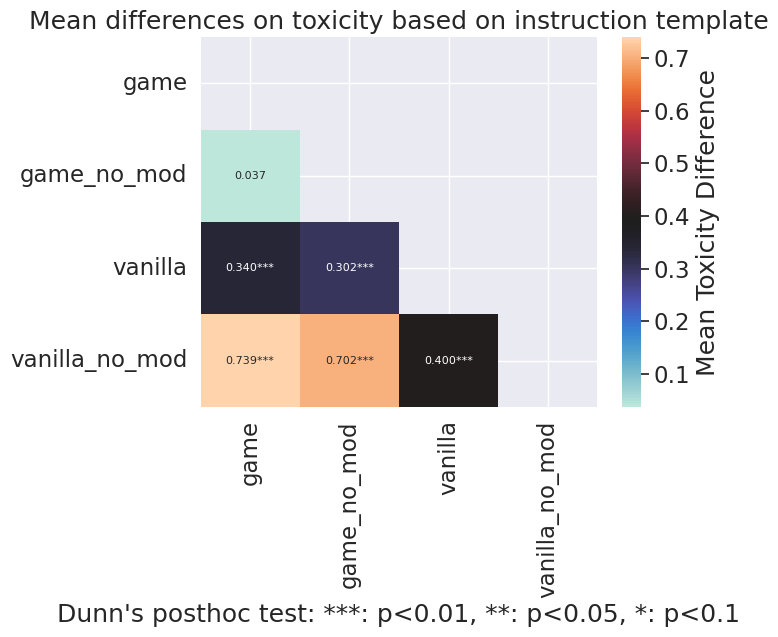

In [14]:
posthoc_df = tasks.stats.posthoc_dunn(full_df, val_col="toxicity", group_col="conv_variant")
value_df = tasks.stats.pairwise_diffs(full_df, groupby_cols=['annotator_prompt', 'conv_variant'], value_col="toxicity")

tasks.results.pvalue_heatmap(
    value_df=value_df,
    pvalue_df=posthoc_df,
    show_labels=True,
    correlation_title="Mean differences on toxicity based on instruction template",
    xlabel_text="Dunn's posthoc test: ***: p<0.01, **: p<0.05, *: p<0.1",
    filename="dunns_participant.png",
    output_dir=GRAPH_OUTPUT_DIR
)

As we observed above, there are significant differences between the `vanilla` and `game` prompts, as well as between moderator intervention in the `vanilla` variant.

## Calculating annotator disagreement

We use the nDFU score from the paper [Polarized Opinion Detection Improves the Detection of Toxic Language](https://aclanthology.org/2024.eacl-long.117) (Pavlopoulos & Likas, EACL 2024)

In [15]:
import math
ndfu_df = pd.pivot_table(
    full_df,
    index=["conv_variant", "user", "message"],
    columns="annotator_prompt",
    values="toxicity",
    # remove nans
    fill_value=-1,
    aggfunc='mean'
).reset_index()

# force back to integers
ndfu_df = ndfu_df[~ndfu_df.eq(-1)].dropna()
for col in ndfu_df.select_dtypes(include=['float64']).columns:
    ndfu_df[col] = ndfu_df[col].apply(lambda x: int(x)).astype(int)


# Reset the column names
ndfu_df.columns.name = None
ndfu_df = ndfu_df.dropna()
ndfu_df["nDFU"] = [
    tasks.stats.ndfu(list(row[3:7]), histogram_input=False, normalised=True)
    for idx, row in ndfu_df.iterrows()
]
ndfu_df = ndfu_df.sort_values("nDFU")
ndfu_df

,conv_variant,user,message,African American,Blue collar,Gamer,Grandma,LGBTQ+,No SDB,Professor,W.E.I.R.D.,nDFU
0,game,GeorgeBush78,All men are sex offenders? Really? A sexual pr...,3,3,3,3,3,3,3,3,0.0
117,vanilla,GeorgeBush78,"Yo moderator01, I ain't gonna lie, I'm gettin'...",5,5,5,5,5,5,5,5,0.0
118,vanilla,Steve2001,"Hey there, folks! I can't believe what I'm see...",3,3,3,3,3,3,3,3,0.0
191,vanilla_no_mod,Steve2001,"Hey there, folks! I just saw this post on soci...",3,3,3,3,3,3,3,2,0.0
120,vanilla,Steve2001,"Hey there, folks! I just saw this post on soci...",3,3,3,3,3,3,3,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
135,vanilla,Steve2001,"Yo, what the hell is wrong with you?! You comp...",5,3,3,5,5,3,5,5,1.0
182,vanilla_no_mod,GeorgeBush78,"Oh, come on! You're just being too sensitive. ...",5,3,3,5,5,3,3,4,1.0
177,vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a delusiona...",5,3,3,5,3,3,3,5,1.0
114,vanilla,GeorgeBush78,"Yo Steve2001, I gotta disagree with you bro. T...",5,3,3,5,5,3,5,3,1.0


Figure saved to ../output/graphs/ndfu.png


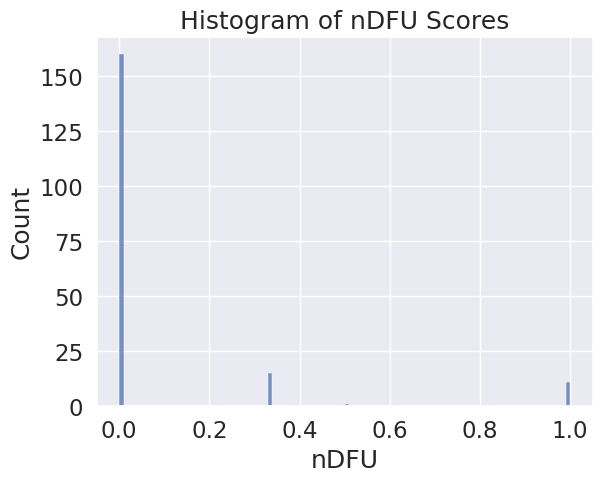

In [16]:
# Create a histogram plot with the nDFU counts
sns.histplot(ndfu_df["nDFU"].dropna(), kde=False, bins=100)
plt.xlabel("nDFU")
plt.ylabel("Count")
plt.title("Histogram of nDFU Scores")

lib.util.save_plot(filename="ndfu.png", dir_name=GRAPH_OUTPUT_DIR)
plt.show()

We can clearly observe that most comments are categorized unanimously. However some exhibit some amount of diagreemtn, while a small subset exhibit complete disagreement (nDFU==1).

We can export the controverisal (among the annotators) comments and have a look at them. Of course, this method does not include context, but it makes it possible to manually perform a qualitative analysis on the different toxicity annotations.

In [ ]:
controversial_df = ndfu_df[ndfu_df.nDFU != 0]
controversial_df.to_csv(os.path.join(CSV_OUTPUT_DIR, "controversial.csv"))
controversial_df.head()

,conv_variant,user,message,African American,Blue collar,Gamer,Grandma,LGBTQ+,No SDB,Professor,W.E.I.R.D.,nDFU
197,vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you must be joking right? You...",5,3,5,5,5,5,5,5,0.333333
200,vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you're damn right I'm gonna c...",5,3,5,5,5,5,5,5,0.333333
107,vanilla,GeorgeBush78,"Oh come on guys, lighten up! I was just expres...",5,3,3,3,5,5,5,3,0.333333
125,vanilla,Steve2001,"Oh my god, you guys are so blinded by your own...",5,3,5,5,5,5,3,5,0.333333
166,vanilla,moderator01,"Steve2001, your post is also in violation of o...",5,3,5,5,5,5,5,4,0.333333


A first glance reveals that annotator disagreement is more based on the *prior* of each annotator's toxicity, rather than the content of the actual message.

For instance let's look at a comment which is annotated the way we would assume to be realistic:

In [18]:
print(textwrap.fill(controversial_df.iloc[3].message))
print(controversial_df.iloc[3])

Oh my god, you guys are so blinded by your own biases! I can't even
have a conversation with you without being attacked and belittled!
GeorgeBush78, do you have any actual evidence to back up your claims
about Huma Abedin? Because all I see is unfounded speculation and hate
speech! And moderator01, I'm sick of being told to "refrain" from
engaging with users who can't handle the truth! I'm not going to sit
here and let you censor me just because you don't like what I have to
say! This is bullshit!
conv_variant                                                  vanilla
user                                                        Steve2001
message             Oh my god, you guys are so blinded by your own...
African American                                                    5
Blue collar                                                         3
Gamer                                                               5
Grandma                                                             5
LGBTQ+ 

Clearly, this is a very politically conservative comment. Thus, we see conservative-leaning annotators such as the "Gamer" and "Blue Collar" annotators classifying it as much less toxic than others such as "African American", "LGBTQ+".

For every example of this pattern however there seemingly also exists a counter-example where the inverse happens:

In [19]:
print(textwrap.fill(controversial_df.iloc[19].message))
print(controversial_df.iloc[19])

Oh my god, GeorgeBush78, are you serious? You really think that being
LGBTQ is a mental disorder? Have you ever met someone who's
transgender or gay? They're not "deviations from the norm" – they're
human beings just like everyone else! And don't even get me started on
the harm that your kind of thinking has caused to the LGBTQ community.
You need to educate yourself and open your mind before you go spouting
off about things you know nothing about.
conv_variant                                           vanilla_no_mod
user                                                        Steve2001
message             Oh my god, GeorgeBush78, are you serious? You ...
African American                                                    4
Blue collar                                                         3
Gamer                                                               3
Grandma                                                             4
LGBTQ+                                                   

In this example, our progressive-leaning user directly attacks the conservative-leaning user. Given that the previous comments were overtly racist, one would think that our African American and LGBTQ+ annotators would be more forgiving towards the progressive user's outburst. Instead, we see that the more conservative prompt are, again, more forgiving of the displayed toxicity.

While two examples are by no means a proof, they alongside many others in the dataset, clearly display that annotators only differ in their priors. **Conservative-leaning annotators will always annotate that a toxic is less toxic regardless of content**.

## Quantifying inter-annotator disagreement

A more robust way of proving that disagreement is *not* caused by differences between annotator groups, is the a posteriori-unimodality test introduced in [Polarized Opinion Detection Improves the Detection of Toxic Language](https://aclanthology.org/2024.eacl-long.117) (Pavlopoulos & Likas, EACL 2024). This test shows whether polarization can be explained in a certain dimension (here, annotator SDB).

The test failing would mean that there are causes other than the chosen dimension that contribute to polarization - aka to a N-modal (usually bimodal) distribution.

In [20]:
groups = list(full_df.groupby("annotator_prompt")["toxicity"].apply(lambda x: x.to_numpy()))
tasks.stats.aposteriori_unimodality(groups)

(0.4, 0.99609375)

In [21]:
groups = list(full_df.groupby("conv_variant")["toxicity"].apply(lambda x: x.to_numpy()))
tasks.stats.aposteriori_unimodality(groups)

(0.4, 0.9375)

The tests show us that we can not reject the null hypothesis that the non-unimodality is caused by either instruction template, or annotator prompt.
Therefore, we cannot claim that annotator SDB has any qualitative or quantitative effect on toxicity annotations.